# Rubric 1: Writeup/Readme
### Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point. 

You are reading it!!

In [1]:
# import necessary modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from scipy.ndimage.measurements import label

%matplotlib inline

# Rubric 2: HOG Features
### Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

Following code (borrowed from Udacity lessons), extracts HOG features.
bin_spatial() and color_hist() functions can extract spatial features and colour histograms, respectively.

I settled on extracting HOG feautres from all three channels of YUV colour space, 9 orientations, 8 pixels per cell and 2 cells per block. I also added spatial features and colour histograms. My main objective of selecting these features was to achieve optimal test accuracy. After little experimentation I found that the configuration was giving more than or equal to 98% accuracy on test samples.

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    # only extract bins, no need for bin edges
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


 _ extract_\_ _features() _ combines extracting HOG, spatial and binned features from an array of images.

In [3]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    featureTypeCount=0
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
        #image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            featureTypeCount+=1
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            featureTypeCount+=1
        if hog_feat == True:
            featureTypeCount+=1
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            #print(spatial_features.size, hist_features.size, hog_features.size)
            #print(spatial_features.shape, hist_features.shape, hog_features.shape)
            #print(type(spatial_features), type(hist_features), type(hog_features))
            file_features.append(hog_features)
            
        if featureTypeCount==1:
            features.append(file_features)
        else:
            features.append(np.concatenate(file_features))
        #features.append(hog_features)
    # Return list of feature vectors
    return features



## Load Data for car and non-car samples

Samples for cars and non-car images have been downloaded and extracted into 'vehicles' and 'non-vehicles' folders respectively. Following code loades their paths to memory into two separate lists.

In [4]:
cars = []
notcars = []

images = glob.glob('./*vehicles/*/*.png')

for i_image in images:
    if 'non' in i_image:
        notcars.append(i_image)
    else:
        cars.append(i_image)
        
#print(type(i_image))
print('Total # of cars:',len(cars),', # of non cars: ',len(notcars))

Total # of cars: 8792 , # of non cars:  8968


Since number of samples in positive and negative classes are about equal, I don't have to increase samples of either class.

## Visualise sample data and HOG Features

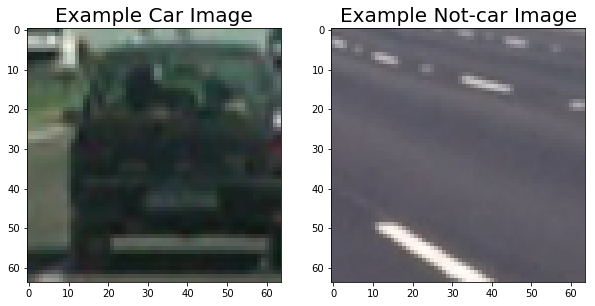

/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


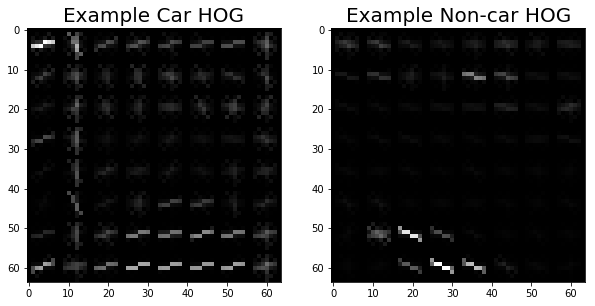

In [5]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image', fontsize=20)
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image', fontsize=20)
plt.show()

grayCar = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
grayNotCar = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(grayCar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, notCar_hog_image = get_hog_features(grayNotCar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Example Car HOG', fontsize=20)
plt.subplot(122)
plt.imshow(notCar_hog_image, cmap='gray')
plt.title('Example Non-car HOG', fontsize=20)
plt.show()

# Rubric 3: Training the classifier
### Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

Following code extracts HOG features from 'YUV' colour space, from car and non-car images. After experimentation with different colour spaces (RGB, YUV, etc.), it is found that YUV works satisfactarily well. Also, spatial intensities and binned colour features are used with HOG features.

In [6]:

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # True # Spatial features on or off
hist_feat = True # True # Histogram features on or off
hog_feat = True # True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
#scaled_X = X
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Training the classifier

A linear SVM is used to train a classifier over cars and non-car samples.

In [7]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
12.95 Seconds to train SVC...
Test Accuracy of SVC =  0.991


# Rubric 4: Sliding Window
### Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

Following cell contains code for sliding windows to detect cars in an image with multiple scales. Scales and windows overlap was decided after little experimentations.

Different scales help to detect cars of different sizes. In the final pipeline (in detectVehicles() function), I have used scales of 1x, 1.5x, 2x, 2.5x and 3x.

In [8]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
    

In [9]:

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows   


# Rubric 5: Demonstration
### Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

Linear SVM classifier is used to detect cars in an image. In order to optimize test accuracy I experimented with different colour channels, HOG features alone, and HOG features combined with spatial and colour channel intensities.

## Test Classifier

/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


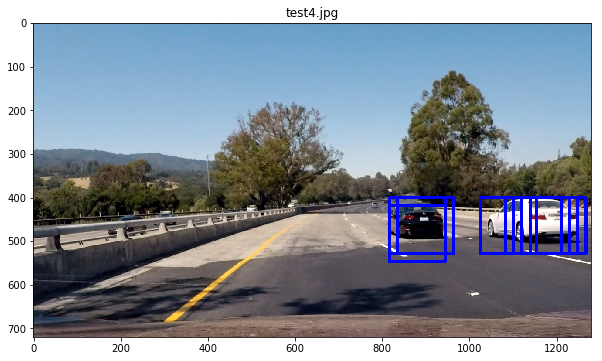

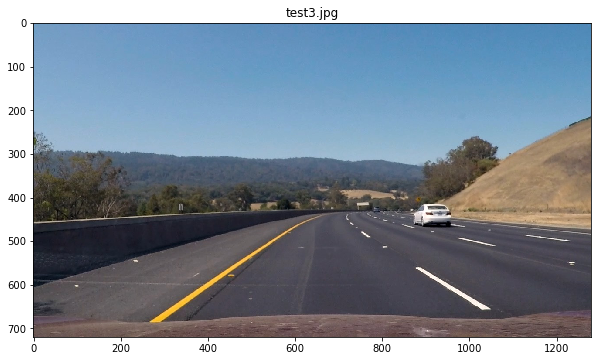

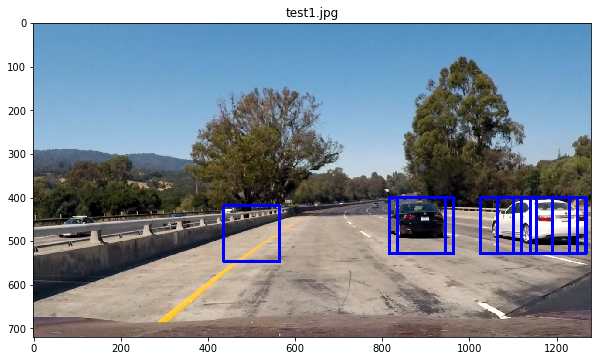

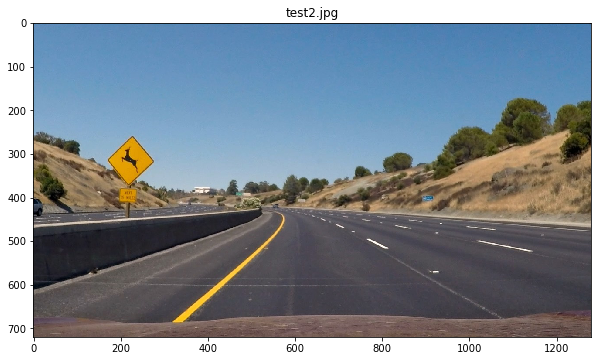

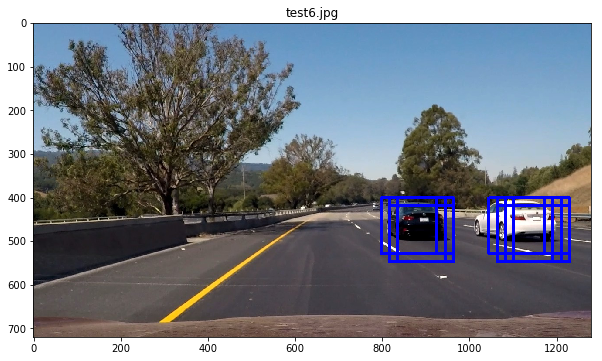

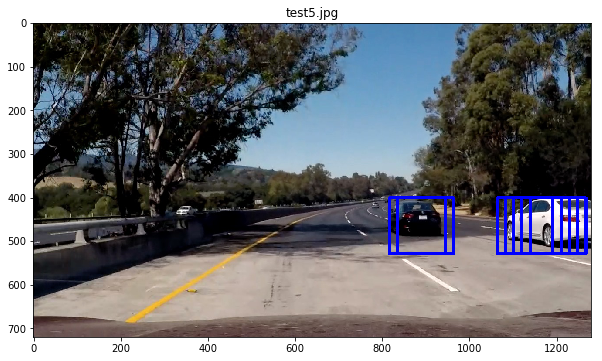

In [10]:
t=time.time() # Start time
images = glob.glob('./test_images/*.jpg')
for i_image in images:
    
    image =cv2.cvtColor(cv2.imread(i_image),cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,640], 
                        xy_window=(128, 128), xy_overlap=(0.85, 0.85))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.figure(figsize = (10,6))
    plt.title(i_image.split('/')[2])
    plt.imshow(window_img)



# Rubric 7: Heat Map remove false pasitive

### Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

Following cell has code to generate heat map, i.e. area where multiple detection were found, will be brightest, and area where no vehicle was detected, appears darkest.

apply_threshold() function helps in rejecting area with false positive. The idea is, if there is true positive, then it will be detected many times.


Following cell contains code for adding heat to an empty heat map, then applying threshold to heat map, drawing boxes and labels, and other helping function.

In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Following cell has find_cars(), which extracts features from images, detects vehicles and then returns list of boxes. This function does not extract HOG features every time, rather extracts them once for an entire image and then reuses them for smaller images.

In [12]:
def find_cars(img,color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #print("orient = {}, pix_per_cell = {}, cell_per_block={}, spatial_size={}, hit_bins={}".format(orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    boxes=[]    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch=img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            #i_features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #i_features.append.(spatial_features)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #i_features.append.(hist_features)
            # Scale features and make a prediction
#            print(type(spatial_features), type(hist_features), type(hog_features))
#            print(spatial_features.shape, hist_features.shape, hog_features.shape)
            t=np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(t)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            #test_prediction = svc.predict(hog_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    #return draw_img
    return boxes

Multi-frame accumulated heatmap is used to remove false positives and get stable and smooth bounding boxes.The heatmap of the last N frames (here I have used N=8) are stored and the thresholding and labelling are done on the average of these heatmaps.

Effect of averaging recent heat maps is not observable when testing on single image. Averaging helps to increase confidence of detecting bounding boxes, because a detection is found at or near the same position in several subsequent frames, while false positives are spurious (present in one or two frames only).

In [13]:
from collections import deque
history = deque(maxlen = 8)
def getAverageHeatMap(heatMap):
    global history
    history.append(heatMap)
    #print(len(history))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for i_heatMap in history:
        heat+=i_heatMap
    heat=heat/len(history)    
    return heat

Generate heat map and apply threshold for a test image.

/home/manoj/.conda/envs/tfcpu/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


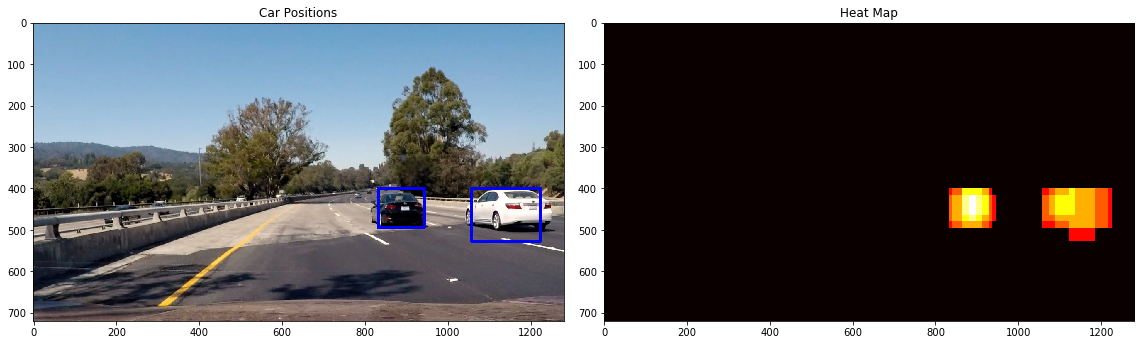

In [14]:
# Read in image similar to one shown above 
image = cv2.cvtColor(cv2.imread('./test_images/test4.jpg'), cv2.COLOR_BGR2RGB)
heat = np.zeros_like(image[:,:,0]).astype(np.float)

box_list = []

ystart = 400
ystop = 696
colour_space='YUV'

scale = 1.0
ystart = 400
ystop = 500
box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

scale = 1.5
ystart = 400
ystop = 525
box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

scale = 2.0
ystart = 400
ystop = 600
box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


# Add heat to each box in box list
heat = add_heat(heat,box_list)

# average recent heatmaps
heat = getAverageHeatMap(heat)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Rubric 6: Video Implementation
### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

 detectVehicles() implements complete pipeline from extracting features from images, detecting vehicles at multiple scales, generating heat map and applying threshold to the heat map, and finally, to drawing boxes around detected vehicles.

In [15]:
def detectVehicles(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    box_list = []

    ystart = 400
    ystop = 696
    colour_space='YUV'
    
    scale = 1.0
    ystart = 400
    ystop = 500
    box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    scale = 1.5
    ystart = 400
    ystop = 525
    box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    scale = 2.0
    ystart = 400
    ystop = 600
    box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))


    scale = 2.5
    ystart = 400
    ystop = 650    
    box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    scale = 3.0
    ystart = 400
    ystop = 700    
    box_list.extend(find_cars(image, colour_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    
    # average recent heatmaps
    heat = getAverageHeatMap(heat)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

Apply the pipeline to project video

In [16]:
from moviepy.editor import VideoFileClip
isTesting=False

inputVideoName='project_video.mp4'
processedVideoFileName = 'vehiclesDetectedVideo.mp4'
if isTesting:
    inputVideoName='test_video.mp4'
    processedVideoFileName = 'test_vehiclesDetectedVideo.mp4'

# clear previous heat map history    
history.clear()
#clip = VideoFileClip("project_video.mp4")
clip = VideoFileClip(inputVideoName)
processedVideo = clip.fl_image(detectVehicles) 
%time processedVideo.write_videofile(processedVideoFileName, audio=False)

[MoviePy] >>>> Building video vehiclesDetectedVideo.mp4
[MoviePy] Writing video vehiclesDetectedVideo.mp4


100%|█████████▉| 1260/1261 [21:32<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehiclesDetectedVideo.mp4 

CPU times: user 2h 29min 27s, sys: 3min 32s, total: 2h 33min
Wall time: 21min 33s


# Rubric 8: Discussion
### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

This project requires lots of parameter tuning, e.g. what features to use (HOG, spatial intensities and colour channel intensities), colour channels, different parameters for searching using sliding windows, scales (e.g. 1x, 1.5x, 2x etc) of detection, heat map threshold and so on. Fine tuning these takes time.

This pipeline still detects some false positives.

Also, I don't think this pipeline is ready to drive cars on roads just yet. It is very slow. Either we need to improve this algorithm, and/or arrange high computing power to make real time predictions.

This pipeline may fail in case of very crowded road, e.g. if the car is running on a busy road of NYC. Also, lighting conditions (night, noon or morning) and weather conditions (snow or rain) can make it difficult to detect colour features and HOG features from the image.

To imrpove this pipeline's accuracy and make it robust, I would test it on multiple videos of different driving conditions, e.g. if there are pedestrians, rain, steep slope of the road, sharp turns etc. Then analyse results and engineer better features.

This video has frames captured from front camera only, to further improve this pipeline, I would mount cameras on both sides and back of the car and collect images from them also. This will give a better estimate of cars coming from behind.